In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']

sns.set_style("white")

### Data Reading

In [2]:
df = pd.read_csv('steam-200k.csv', header=None, index_col=None, names=['user', 'game', 'purchase_play', 'hours', 'other'])
df

,user,game,purchase_play,hours,other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0
...,...,...,...,...,...
199995,128470551,Titan Souls,play,1.5,0
199996,128470551,Grand Theft Auto Vice City,purchase,1.0,0
199997,128470551,Grand Theft Auto Vice City,play,1.5,0
199998,128470551,RUSH,purchase,1.0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user           200000 non-null  int64  
 1   game           200000 non-null  object 
 2   purchase_play  200000 non-null  object 
 3   hours          200000 non-null  float64
 4   other          200000 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.6+ MB


In [4]:
print("Number of games : {0}".format(len(df.game.unique())))
print("Number of users : {0}".format(len(df.user.unique())))

Number of games : 5155
Number of users : 12393


### Data Cleaning 

In [5]:
#Drop 'other' column - insignificant 
df.drop(['other'], inplace=True, axis=1)
df

,user,game,purchase_play,hours
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0
...,...,...,...,...
199995,128470551,Titan Souls,play,1.5
199996,128470551,Grand Theft Auto Vice City,purchase,1.0
199997,128470551,Grand Theft Auto Vice City,play,1.5
199998,128470551,RUSH,purchase,1.0


In [6]:
# Check and drop Nulls if any 
print("prior shape: ", df.shape)
df.dropna(how='any', inplace=True)
print("post shape: ", df.shape)

prior shape:  (200000, 4)
post shape:  (200000, 4)


#### Handling Duplicated values

There should have only two rows max per user per game: one for Purchase and one for Play

There might be duplicates purchases if the user has purchased the same game more than once, in cases whereby the user intends to give to friends to play. 

In [7]:
df.drop_duplicates(subset=['user','game','purchase_play'], keep='first', inplace=True)

In [8]:
print ("Number of rows dropped : ",200000-199281)

# Updated info on dataset
print("Number of games : {0}".format(len(df.game.unique())))
print("Number of users : {0}".format(len(df.user.unique())))

Number of rows dropped :  719
Number of games : 5155
Number of users : 12393


We see that we have dropped 719 records, but there is no user or game lost in the process.

#### Feature Engineering 

I am splitting out the purchase/play column into two columns. The data collection essentially duplicates each record with one labelled as 'purchase' and one labelled as 'play'. The 'purchase' row records 1 hour. Clearly this doesn't make any sense so I will remove this in the process of splitting the column and keep only the genuine 'play' hours.

In [9]:
def purchase_split(data):
    if data['purchase_play'] == 'purchase':
        return 1
    else:
        return 0
    
def play_split(data):
    if data['purchase_play'] == 'play':
        return 1
    else:
        return 0
    
def play_hours_split(data):
    return data['hours'] - data['purchase']

In [10]:
df['purchase'] = df.apply (lambda data: purchase_split(data), axis=1)
df['play'] = df.apply (lambda data: play_split(data), axis=1)
df['hours'] = df.apply (lambda data: play_hours_split(data), axis=1)
df_cleaned = df.groupby(['user','game']).sum().reset_index()

In [11]:
df_cleaned

,user,game,hours,purchase,play
0,5250,Alien Swarm,4.9,1,1
1,5250,Cities Skylines,144.0,1,1
2,5250,Counter-Strike,0.0,1,0
3,5250,Counter-Strike Source,0.0,1,0
4,5250,Day of Defeat,0.0,1,0
...,...,...,...,...,...
128799,309626088,Age of Empires II HD Edition,6.7,1,1
128800,309812026,Counter-Strike Nexon Zombies,0.0,1,0
128801,309812026,Robocraft,0.0,1,0
128802,309824202,Dota 2,0.7,1,1


In [12]:
print("Number of games : {0}".format(len(df_cleaned.game.unique())))
print("Number of users : {0}".format(len(df_cleaned.user.unique())))

Number of games : 5155
Number of users : 12393


## Details on Cleaned Dataset: 
- Total of 200,000 -> 128,804 records
- 5,155 unique games 
- 12,393 unique users. 

### Data Exploration 

Let's see if the most purchased games correspond to the most played games

In [13]:
game_total_users=pd.DataFrame(df_cleaned.groupby(df_cleaned['game'])['user'].count())

In [14]:
game_total_hrs = df_cleaned.groupby(by='game')['hours'].sum()
most_played_games = game_total_hrs.sort_values(ascending=False)[:20]

In [26]:
# game with the highest number of users

game_freq = df_cleaned.groupby(by='game').agg({'user': 'count', 'hours': 'sum'}).reset_index()
top10user = game_freq.sort_values(by='user',ascending=False)[:10].reset_index()

top10user['hours'] = top10user['hours'].round(0)
top10user['hours'] = top10user['hours'].astype(int)

print(top10user)

   index                             game  user   hours
0   1336                           Dota 2  4841  981685
1   4257                  Team Fortress 2  2323  173673
2   4788                         Unturned  1563   16096
3    981  Counter-Strike Global Offensive  1412  322772
4   2074           Half-Life 2 Lost Coast   981     184
5    984            Counter-Strike Source   978   96076
6   2475                    Left 4 Dead 2   951   33597
7    978                   Counter-Strike   856  134261
8   4899                         Warframe   847   27075
9   2071           Half-Life 2 Deathmatch   823    3713


In [27]:
top10hours = game_freq.sort_values(by='hours',ascending=False)[:10].reset_index()

top10hours['hours'] = top10hours['hours'].round(0)
top10hours['hours'] = top10hours['hours'].astype(int)

print(top10hours)

   index                                         game  user   hours
0   1336                                       Dota 2  4841  981685
1    981              Counter-Strike Global Offensive  1412  322772
2   4257                              Team Fortress 2  2323  173673
3    978                               Counter-Strike   856  134261
4   3825                   Sid Meier's Civilization V   596   99821
5    984                        Counter-Strike Source   978   96076
6   4364                   The Elder Scrolls V Skyrim   717   70889
7   1894                                  Garry's Mod   731   49725
8    737  Call of Duty Modern Warfare 2 - Multiplayer   343   42010
9   2475                                Left 4 Dead 2   951   33597


C:\Users\HP\anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


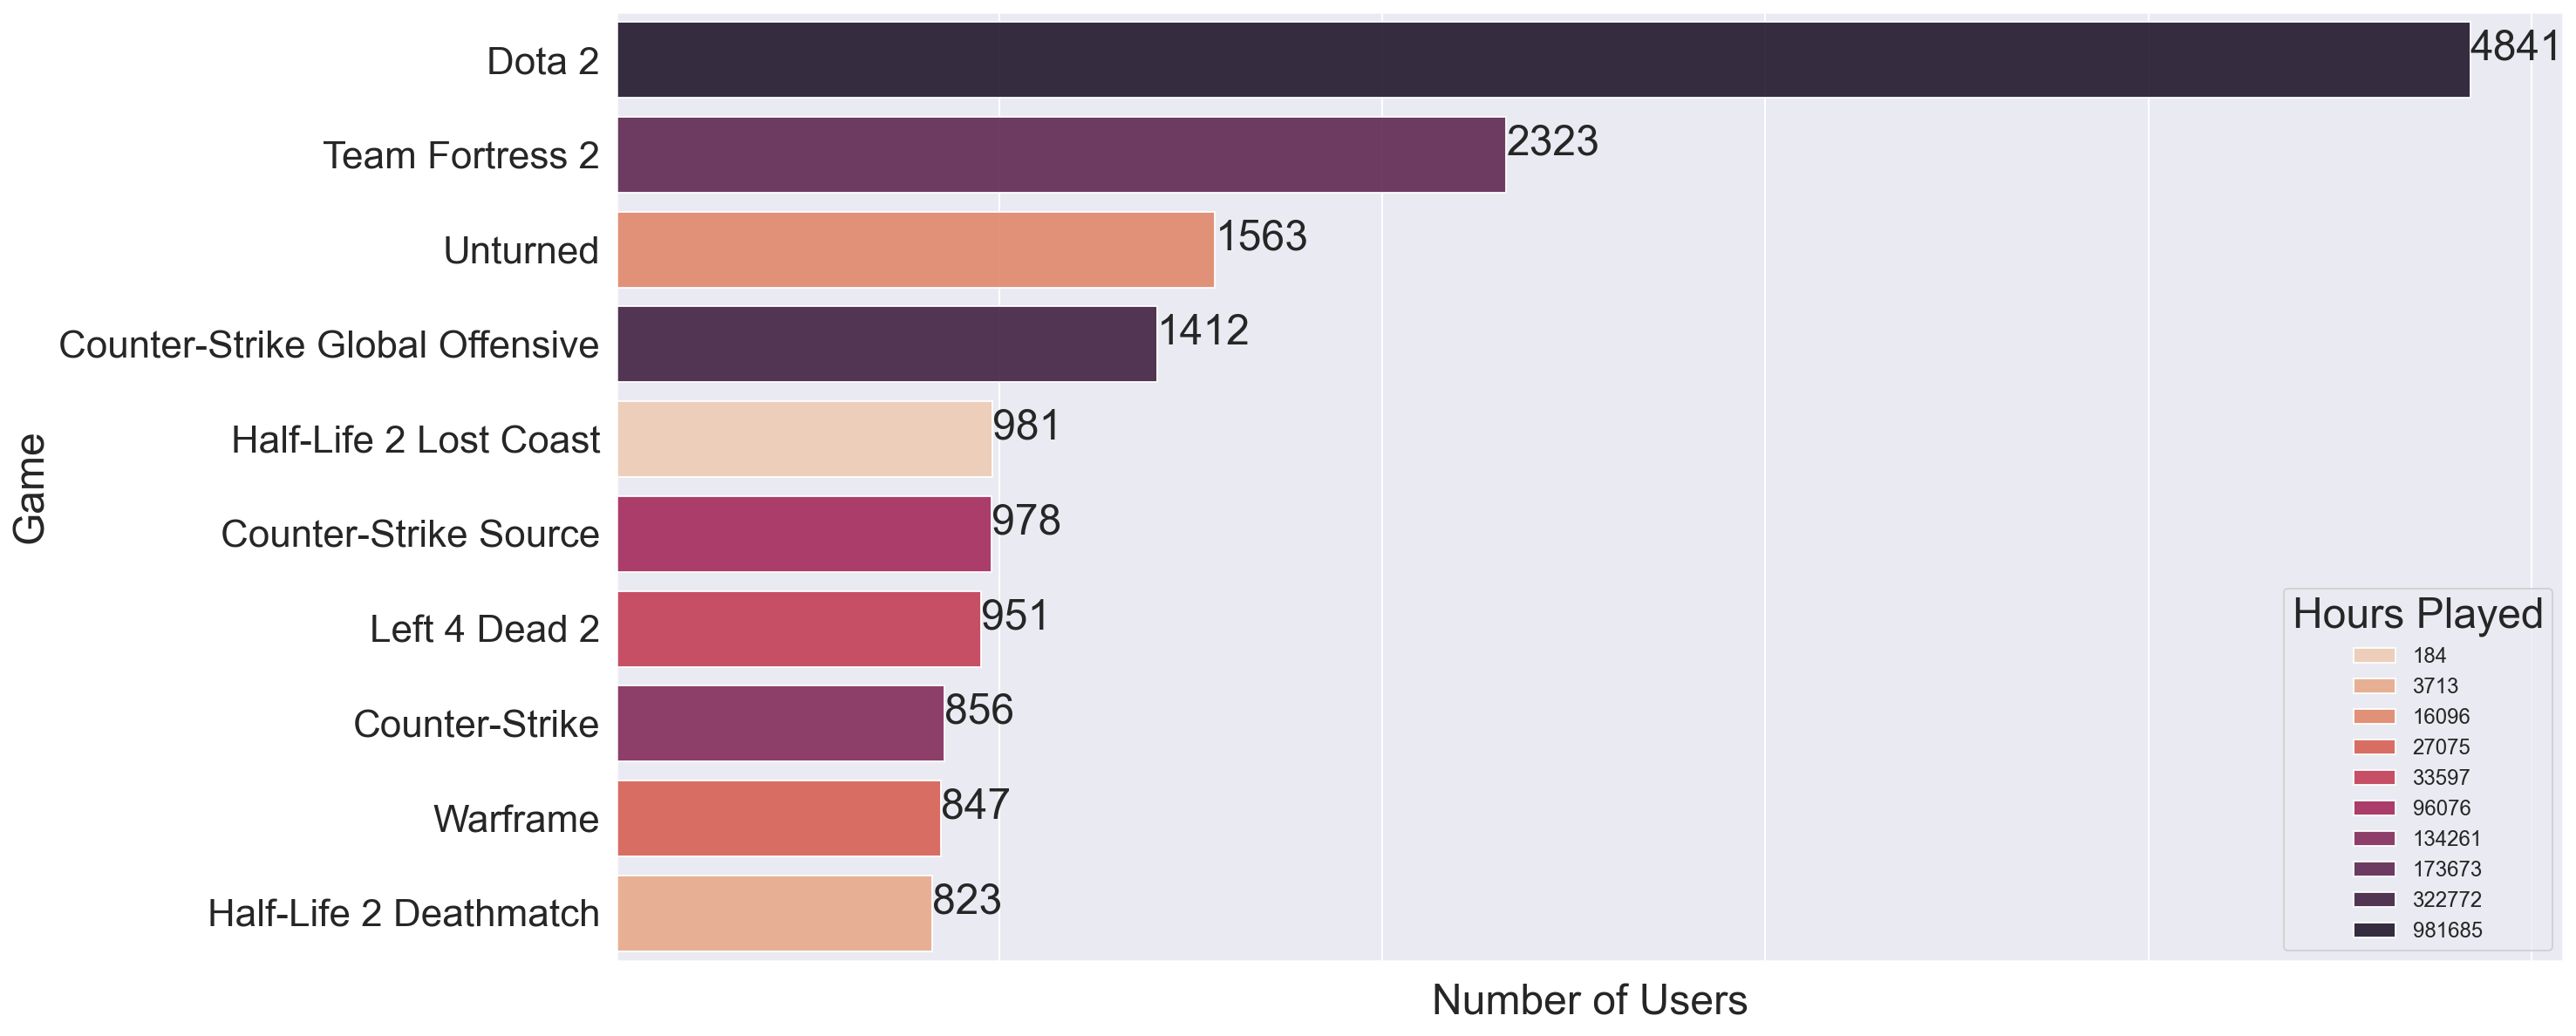

In [45]:
# plot histogram

plt.figure(figsize=(20, 10))
sns.set(font_scale = 2)
ax = sns.barplot(x='user', y='game', hue='hours',alpha=0.9,data=top10user, palette='rocket_r',dodge=False)
ax.set(xlabel='Number of Users', ylabel='Game')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(fontsize=12, title='Hours Played')
for index, value in enumerate(top10user.user):
    plt.text(value, index, str(value))
plt.show()

We can see that for some games, there is a relation between most played and most purchased. For example, ‘Dota 2’ is undeniably the most popular game, it has the most number of users and the most total of hours played. 

However, this is not always the case, an interesting example is ‘Half-Life 2 Lost Coast’ which has a high number of users (981 users), but the total of hours played is quite low (184 hours). A possible explanation for this could be that this game was purchased as part of a game bundle (i.e. in most cases a free The 'pack-in' game). Games like these add noise to the dataset.

#### In order to have a better understanding of the user data distribution and user’s playing habits, a box plot is produced for the top 20 most played game, based in the total of hours played.

In [20]:
#Finding top 10 most played games (by hours)
df_cleaned.groupby(df_cleaned['game'])['hours'].sum().sort_values(ascending=False).head(10)

game
Dota 2                                         981684.6
Counter-Strike Global Offensive                322771.6
Team Fortress 2                                173673.3
Counter-Strike                                 134261.1
Sid Meier's Civilization V                      99821.3
Counter-Strike Source                           96075.5
The Elder Scrolls V Skyrim                      70889.3
Garry's Mod                                     49725.3
Call of Duty Modern Warfare 2 - Multiplayer     42009.9
Left 4 Dead 2                                   33596.7
Name: hours, dtype: float64

In [21]:
df_hours = df_cleaned.sort_values(['hours'], ascending=False)

In [22]:
df_hours=df_cleaned[df_cleaned['game'].isin(['Dota 2','Counter-Strike Global Offensive','Team Fortress 2',
                                             'Counter-Strike',"Sid Meier's Civilization V",'Counter-Strike Source', 
                                             'The Elder Scrolls V Skyrim',"Garry's Mod",
                                             'Call of Duty Modern Warfare 2 - Multiplayer','Left 4 Dead 2'])]
df_hours

,user,game,hours,purchase,play
2,5250,Counter-Strike,0.0,1,0
3,5250,Counter-Strike Source,0.0,1,0
7,5250,Dota 2,0.2,1,1
19,5250,Team Fortress 2,0.8,1,1
30,76767,Call of Duty Modern Warfare 2 - Multiplayer,165.0,1,1
...,...,...,...,...,...
128788,309262440,Team Fortress 2,1.2,1,1
128794,309404240,Team Fortress 2,2.2,1,1
128797,309434439,Dota 2,0.8,1,1
128802,309824202,Dota 2,0.7,1,1


In [23]:
df_hours['game'] = pd.Categorical(df_hours['game'],  ['Dota 2','Counter-Strike Global Offensive',
                                                      'Team Fortress 2','Counter-Strike',"Sid Meier's Civilization V",
                                                      'Counter-Strike Source', 'The Elder Scrolls V Skyrim',
                                                      "Garry's Mod",'Call of Duty Modern Warfare 2 - Multiplayer',
                                                      'Left 4 Dead 2'])
df_hours = df_hours.sort_values("game")

C:\Users\HP\anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


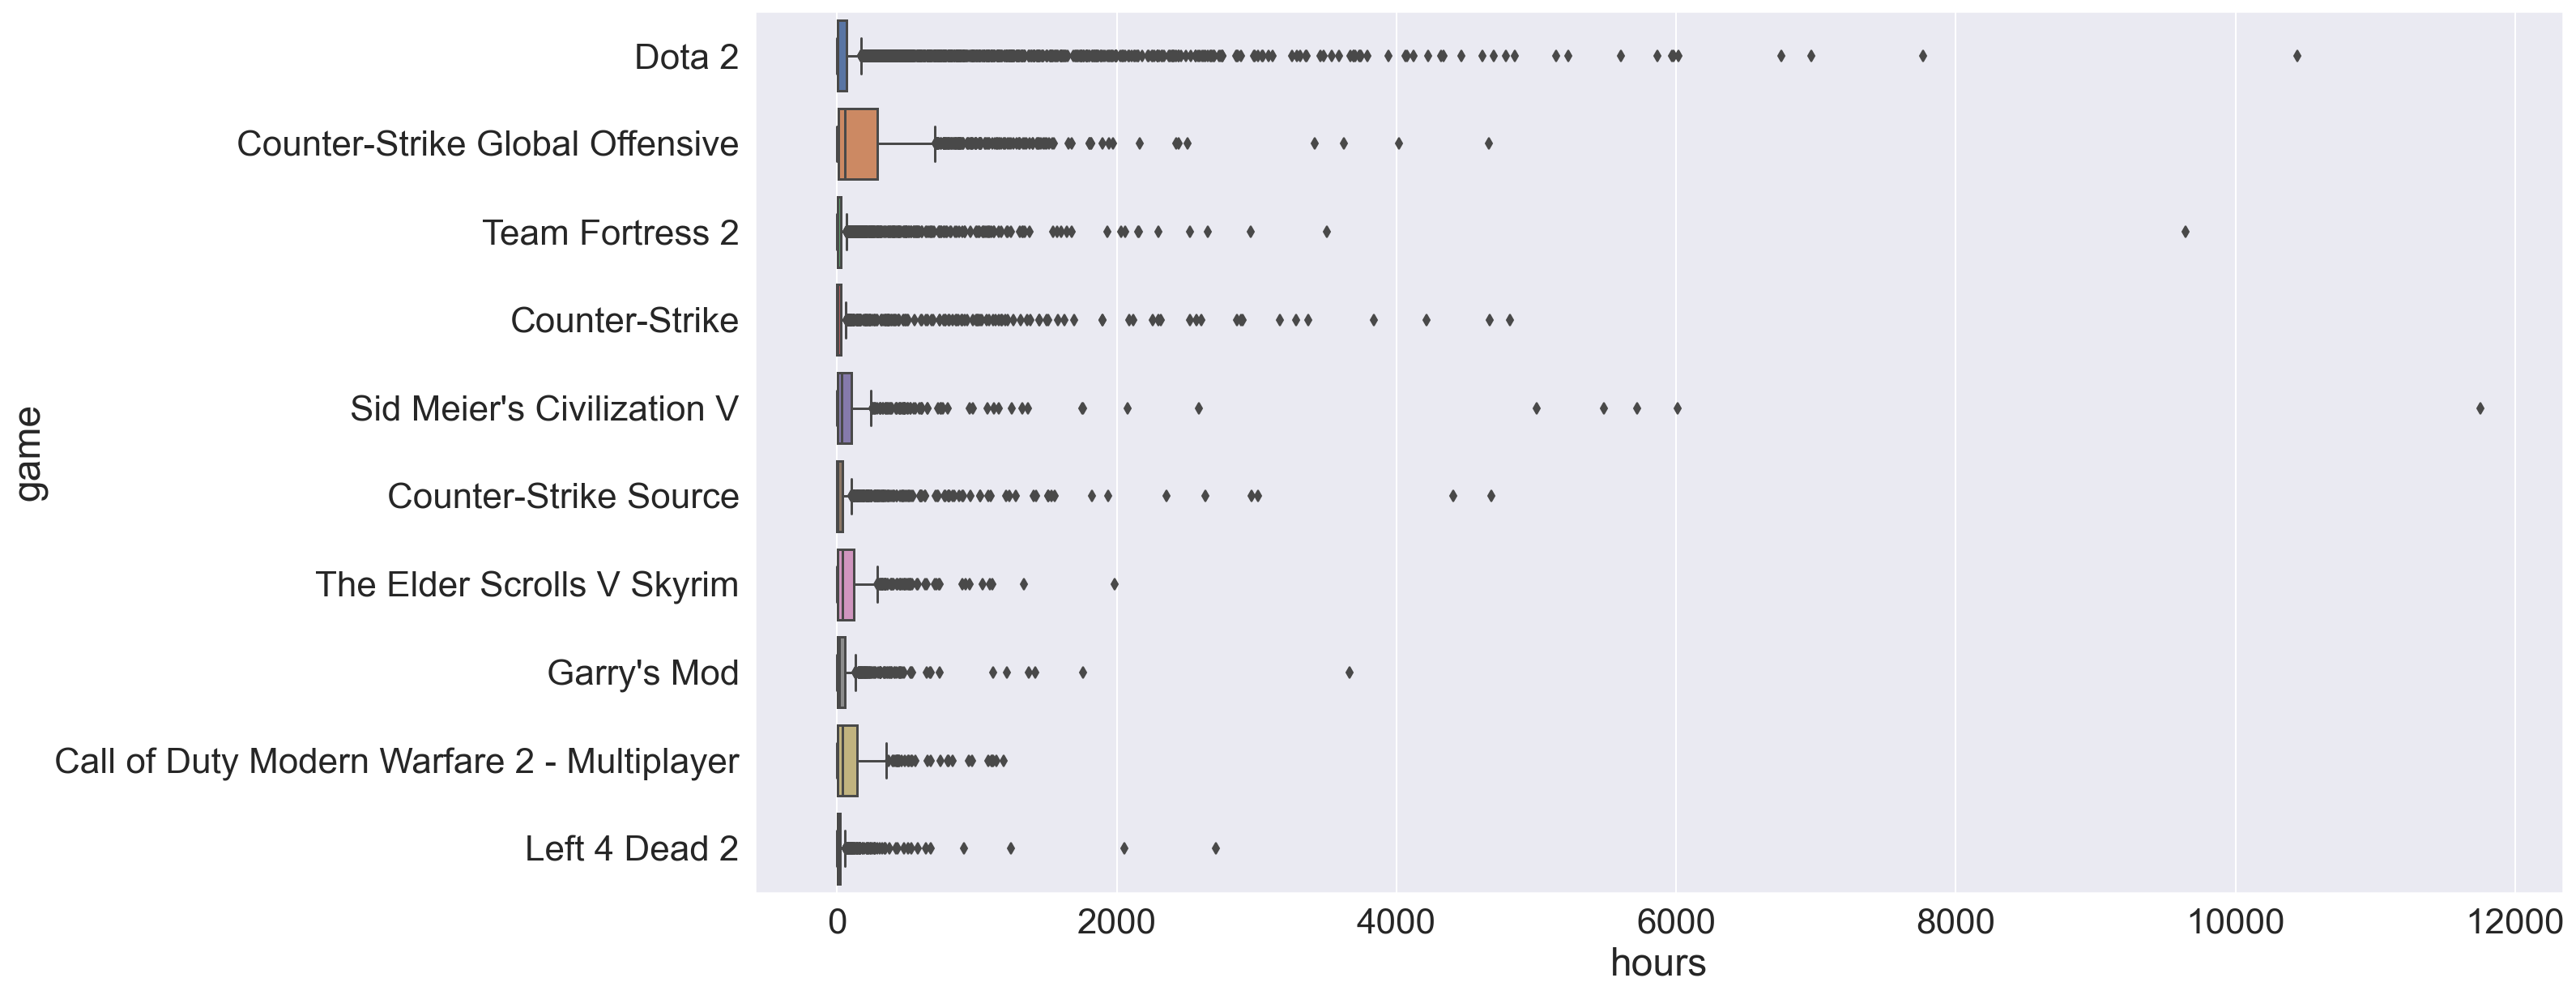

In [46]:
plt.figure(figsize=(20,10))
# plt.title('Boxplot: Top 10 most played games based on Total no. of Hours')
sns.boxplot(data=df_hours, x=df_hours.hours,y=df_hours.game)
plt.show()

As we can see, the data distribution for each game considered is not symmetrical. Even more, 75% of data points for each game is in the range of hundreds of hours, with several games having very large outliers. We can see for example a user played more than 10,000 hours “Dota 2”. Another interesting example, a top user in playing hours has played almost 12,000 hours “Sid Meier’s Civilization V”. 

This graphs shows that there are indeed hardcore gamers who spend lots of hours in games they loved or professional gamers who played the game to hone their skills. It is clear that they have contributed a huge bulk of hours to the total hours game played among all the users, 

???? THINK MORE: therefore it might not be good to rely on total of hours played to make up recommender system. Second reason can be the game is just time-comsuming in nature that's why users spend lots of time on it, is not necessarily indicates the game is good.

In [25]:
# Finding out how many purchased but did not play
print("Total game purchases : {0}".format(len(df_cleaned.loc[df_cleaned['purchase'] == 1])))
print("Total game plays : {0}".format(len(df_cleaned.loc[df_cleaned['play'] == 1])))
print("Number of purchased games not played : {0}".format((len(df_cleaned.loc[df_cleaned['purchase'] == 1]))-(len(df_cleaned.loc[df_cleaned['play'] == 1]))))
user_filter=((df_cleaned["play"]==0))
print("Number of users who purchased game without playing: {0}".format(df_cleaned[user_filter]["user"].nunique()))

Total game purchases : 128804
Total game plays : 70477
Number of purchased games not played : 58327
Number of users who purchased game without playing: 5953


In [ ]:
# df_cleaned.to_csv (r'C:\Users\HP\Metis\my_fourth_project\steam-200k-cleaned.csv', index = False, header=True)